In [1]:
using CircularArrays,Plots

In [25]:
"""
    toomSiteFuture(code::CircularArray,r)

return the propsed future state of the site r=i,j according to the toom's rule
"""
function toomSiteFuture(code::CircularArray,r)
    i,j=r
    
    if code[i,j]+code[i+1,j]+code[i,j+1] >= 2 
        return 1
    else
        return 0
   end
end

"""
    toomUpdate!(code::CircularArray,p,q)

one step update of the lattice code according to toom's rule with parameters p and q
"""
function toomUpdate(code::CircularArray,p,q)
    l=size(code,1)
    futureCode=CircularArray(zeros(UInt8,l,l))
    for i in axes(code,1)
        for j in axes(code,2)
            futureCode[i,j]=toomSiteFuture(code,(i,j))
            if futureCode[i,j]==1 && rand()<q
                futureCode[i,j]=0
            elseif futureCode[i,j]==0 && rand()<p
                futureCode[i,j]=1
            end
        end
    end
    return futureCode
end

toomUpdate

In [42]:
avgNum=1000

ls=[2,4,8,16]
ps=collect(0:0.02:1)


data=Array{Any}(undef,length(ls),length(ps))


for i_l in eachindex(ls)
    l=ls[i_l]
    T=5*l
    println("\nl:$l")
    for i_p in eachindex(ps)
        p=ps[i_p]
        print("p:$p| ")
        k=0
        for r in 1:avgNum
            code=CircularArray(zeros(UInt8,l,l))
            for t in 1:T
                code=toomUpdate(code,p,p)
            end
            if sum(code) > l*l/2 
                k+=1
            else
                k+=0
            end
        end
        data[i_l,i_p]=k/avgNum
    end
end




l:2
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| p:0.52| p:0.54| p:0.56| p:0.58| p:0.6| p:0.62| p:0.64| p:0.66| p:0.68| p:0.7| p:0.72| p:0.74| p:0.76| p:0.78| p:0.8| p:0.82| p:0.84| p:0.86| p:0.88| p:0.9| p:0.92| p:0.94| p:0.96| p:0.98| p:1.0| 
l:4
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.48| p:0.5| p:0.52| p:0.54| p:0.56| p:0.58| p:0.6| p:0.62| p:0.64| p:0.66| p:0.68| p:0.7| p:0.72| p:0.74| p:0.76| p:0.78| p:0.8| p:0.82| p:0.84| p:0.86| p:0.88| p:0.9| p:0.92| p:0.94| p:0.96| p:0.98| p:1.0| 
l:8
p:0.0| p:0.02| p:0.04| p:0.06| p:0.08| p:0.1| p:0.12| p:0.14| p:0.16| p:0.18| p:0.2| p:0.22| p:0.24| p:0.26| p:0.28| p:0.3| p:0.32| p:0.34| p:0.36| p:0.38| p:0.4| p:0.42| p:0.44| p:0.46| p:0.

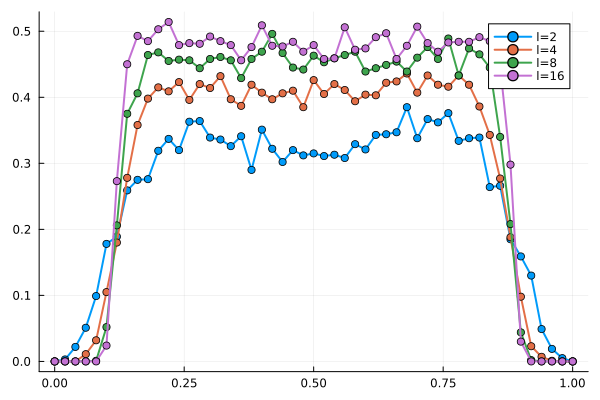

In [45]:
plt=plot()
for i_l in eachindex(ls)
    l=ls[i_l]
    Ys=[]
    for i_p in eachindex(ps)
        push!(Ys, data[i_l,i_p])
    end
    plot!(plt,ps,Ys,label="l=$l",marker=:circle,lw=2)
end
display(plt)